In [2]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic, shapelets
from gigalens.tf.profiles.mass import epl, shear, sis
import gigalens
sns.set_style("whitegrid")
tfd = tfp.distributions

In [3]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.0), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)

n_max = 5
amp_prior = {key: tfd.Normal(0,200) for key in shapelets.Shapelets(n_max)._amp_names}
source_light_params = dict(
    beta=tfd.LogNormal(tf.math.log(0.15), 0.15),
    center_x=tfd.Normal(0, 0.25),
    center_y=tfd.Normal(0, 0.25)
)

source_light_prior = tfd.JointDistributionSequential([tfd.JointDistributionNamed(dict(**source_light_params, **amp_prior))])
source_light_prior_noamp = tfd.JointDistributionSequential([tfd.JointDistributionNamed(source_light_params)])

prior = tfd.JointDistributionSequential(
    [lens_prior, source_light_prior]
)
prior_noamp = tfd.JointDistributionSequential(
    [lens_prior, source_light_prior_noamp]
)

2022-05-03 18:28:51.498451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 18:28:53.228209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2022-05-03 18:28:53.234693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38419 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-05-03 18:28:53.235342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/devi

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [4]:
tf.random.set_seed(101)
truth = prior.sample(1)

2022-05-03 18:28:55.341765: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x560b03f00e60


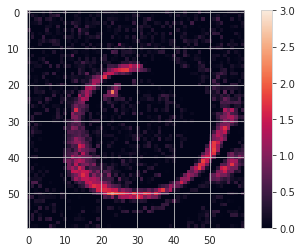

In [5]:
import gigalens
root = gigalens.__path__[0] + '/assets'
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=1)
phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=False, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = lens_sim.simulate(truth)
err_map = np.sqrt(0.2**2 + np.clip(observed_img, 0, np.inf)/50)
np.random.seed(1)
observed_img += np.random.normal(scale=err_map)

phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=True, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = BackwardProbModel(prior_noamp, observed_img, background_rms=0.2, exp_time=50)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)
plt.imshow(observed_img, vmin=0, vmax=3)
plt.colorbar() 

Begin fitting.

In [14]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

See $\S2.3$: Maximum a Posteriori Estimate

In [15]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 100, 1e-2/10)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=100, num_steps=150, seed=0)

  0%|          | 0/150 [00:00<?, ?it/s]

In [16]:
# Simulator to evaluate the log likelihood of 500 candidate solutions
lens_sim_100 = LensSimulator(phys_model, sim_config, bs=100)
lps = prob_model.log_prob(lens_sim_100, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

See $\S2.4$: Variational Inference

In [22]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 100, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
import time
a = time.time()
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=350)
print(time.time()-a)

664.1947665214539


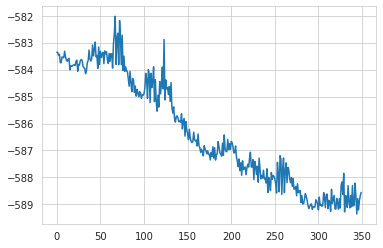

In [23]:
plt.plot(losses)

See $\S2.5$: Hamiltonian Monte Carlo

In [24]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/global/homes/a/andigu/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [25]:
Rhat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, prob_model.bij.forward(samples))
ESS = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), prob_model.bij.forward(samples))
Rhat, ESS

([[{'theta_E': <tf.Tensor: shape=(), dtype=float32, numpy=1.010391>,
    'gamma': <tf.Tensor: shape=(), dtype=float32, numpy=1.0233704>,
    'e2': <tf.Tensor: shape=(), dtype=float32, numpy=1.0002288>,
    'e1': <tf.Tensor: shape=(), dtype=float32, numpy=1.0001783>,
    'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=1.0007309>,
    'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=1.0004048>},
   {'gamma2': <tf.Tensor: shape=(), dtype=float32, numpy=1.0003132>,
    'gamma1': <tf.Tensor: shape=(), dtype=float32, numpy=1.0161821>}],
  [{'center_y': <tf.Tensor: shape=(), dtype=float32, numpy=1.019573>,
    'center_x': <tf.Tensor: shape=(), dtype=float32, numpy=1.0050339>,
    'beta': <tf.Tensor: shape=(), dtype=float32, numpy=1.0210369>}]],
 [[{'theta_E': <tf.Tensor: shape=(), dtype=float32, numpy=6344.4556>,
    'gamma': <tf.Tensor: shape=(), dtype=float32, numpy=2598.583>,
    'e2': <tf.Tensor: shape=(), dtype=float32, numpy=30989.139>,
    'e1': <tf.Tensor: shape=(), dtype

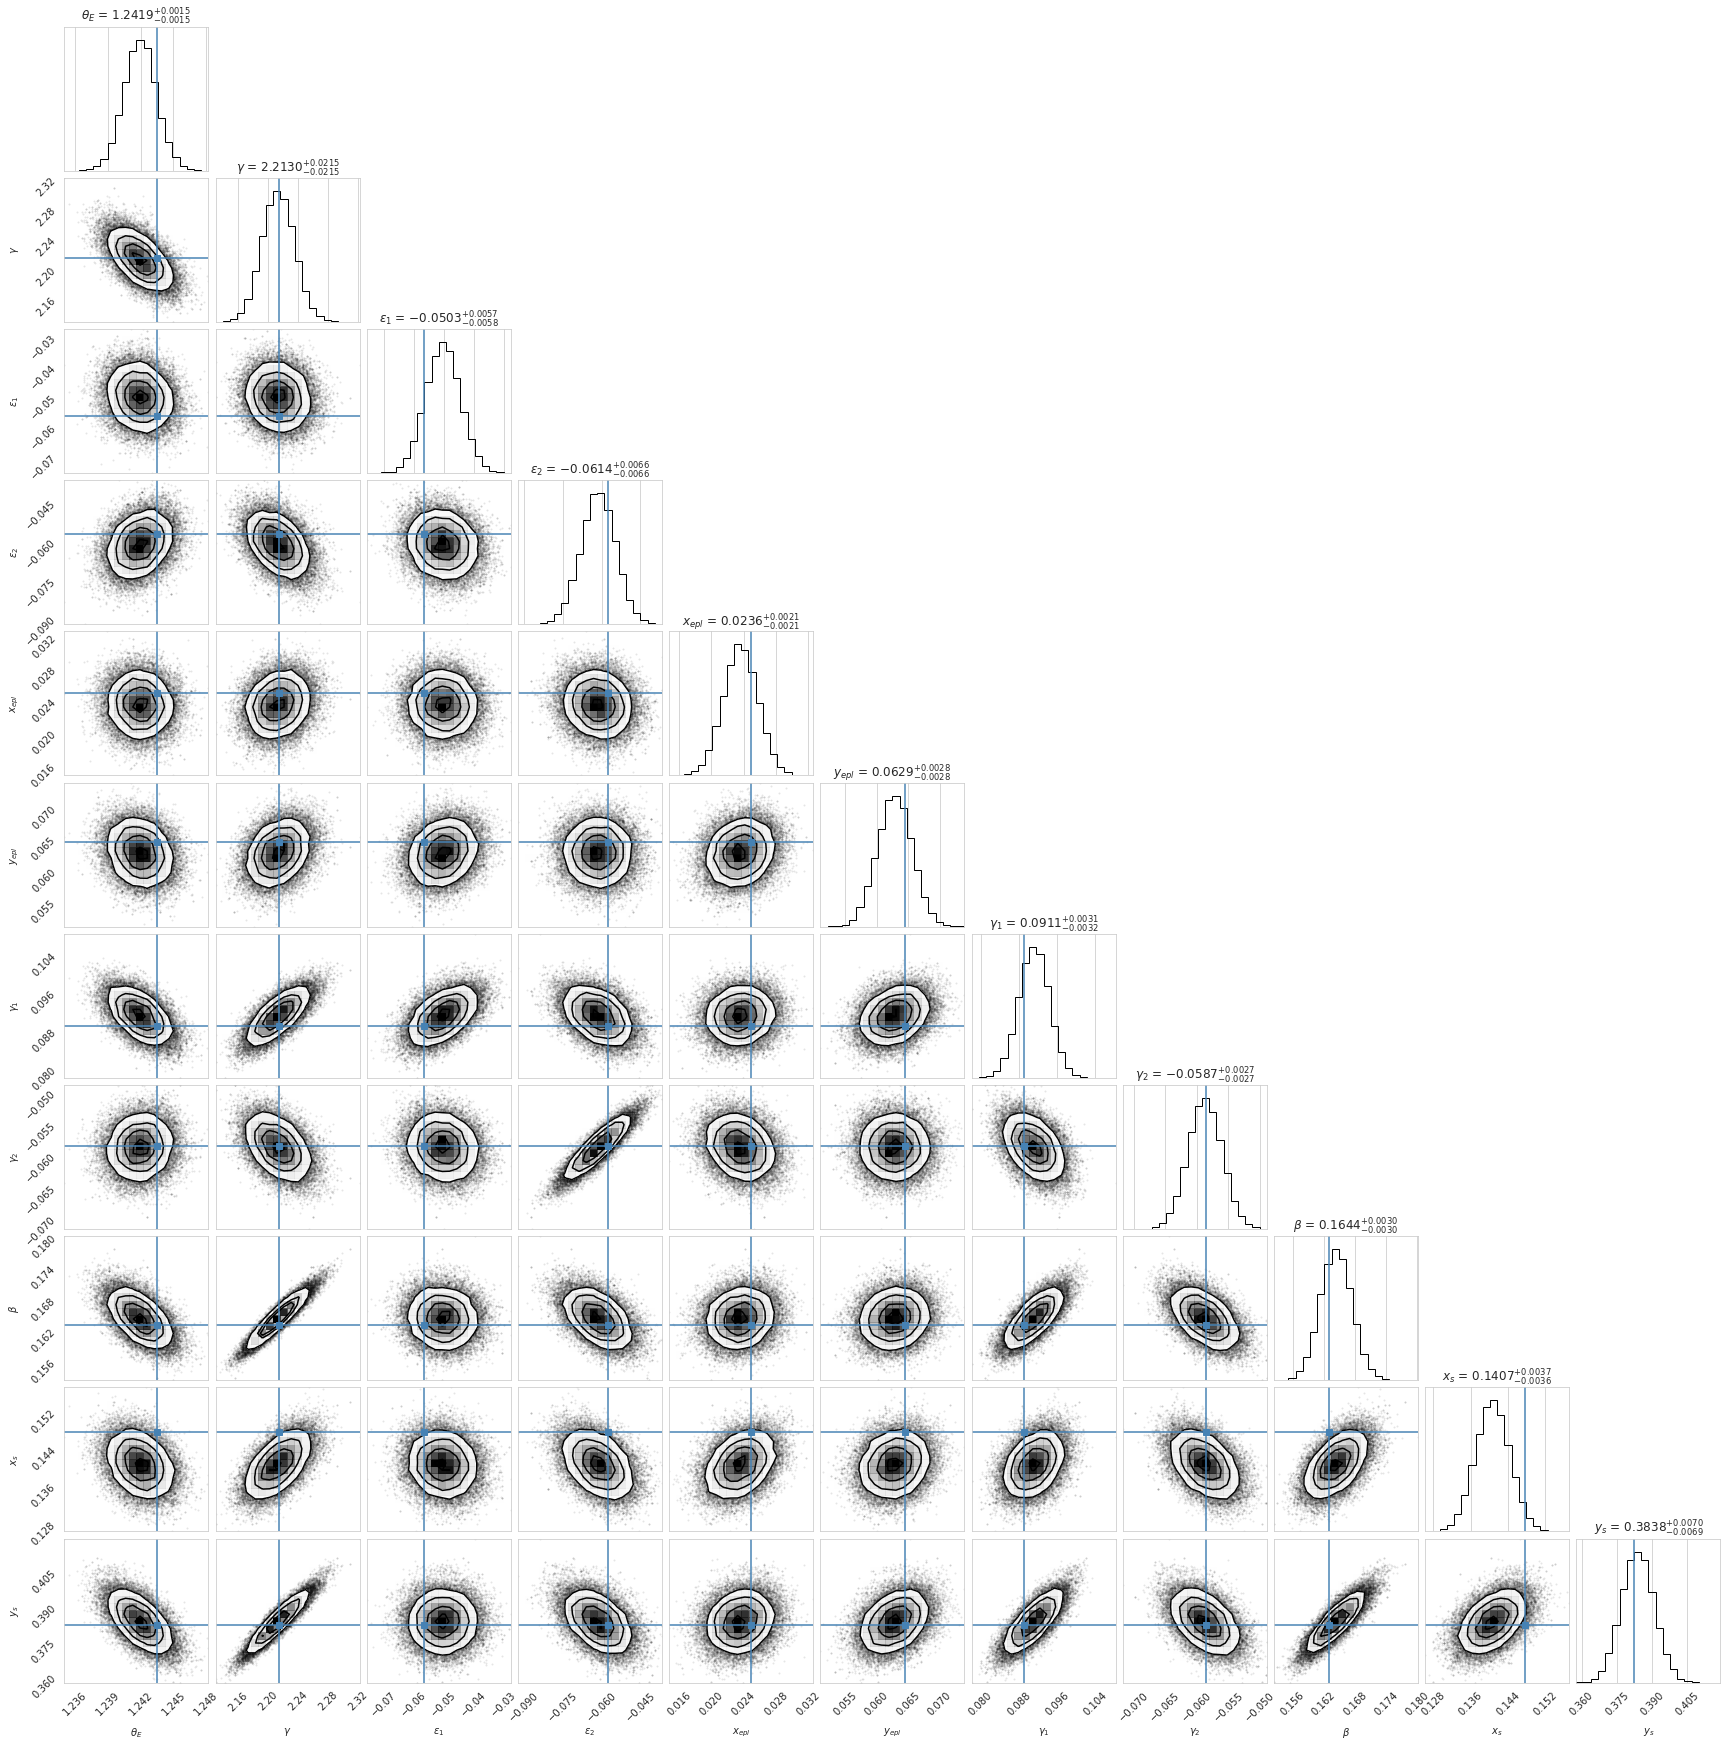

In [26]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
    x[1][0]['beta'],
    x[1][0]['center_x'],
    x[1][0]['center_y'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth).numpy().flatten()
labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x_{epl}$', r'$y_{epl}$', r'$\gamma_1$', r'$\gamma_2$', r'$\beta$', r'$x_s$', r'$y_s$']
corner(physical_samples.reshape((len(labels),-1)).T, truths=markers, 
       show_titles=True, title_fmt='.4f',
       labels=labels);